In [8]:
import cv2
import numpy as np
import os
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt 

In [9]:
def load_images_from_folder(folder,count=None,size=None):
    images = []
    i = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            i += 1
            if i%50 == 0:
                clear_output()
                print (i)
            if count is not None:
                if count == 0:
                       break
                else:
                    count -= 1
            
            if size is not None:
                img = cv2.resize(img,size,interpolation = cv2.INTER_CUBIC)
            images.append((filename,img))

    return images

In [4]:
melanoma = load_images_from_folder('./data/melanoma',None,(256,128))

350


In [5]:
others = load_images_from_folder('./data/others',None,(256,128))

1600


In [3]:
def make_melanoma_classification_dataset(data,gt_path):
    classification_dataset = []
    
    for filename in os.listdir(gt_path):
        for data_list in data:
            entry = [row[1] for row in data_list if row[0][:-4] in filename[:-4]]
            if entry:
                gt_img = cv2.imread(os.path.join(gt_path,filename),0)
                gt_img = cv2.resize(gt_img,(entry[0].shape[1],entry[0].shape[0]),interpolation = cv2.INTER_CUBIC)
                #gt_img = gt_img.reshape((gt_img.shape[0],gt_img.shape[1],1))
                
                mask = gt_img < 150
                train_img = entry[0]
                train_img[mask] = 0
                
                label = int(len(data_list) < 500)
                classification_dataset.append((train_img,label))
                
                    

    return classification_dataset
        
        

In [7]:
dataset = make_melanoma_classification_dataset([melanoma,others],'./data/gt/')

In [8]:
#Splitting for training and testing
train_size = int(len(dataset)*0.8)

x_train = np.array([row[0]/255. for row in dataset[0:train_size]])
y_train = np.array([row[1] for row in dataset[0:train_size]])

x_test = np.array([row[0]/255. for row in dataset[train_size:]])
y_test = np.array([row[1] for row in dataset[train_size:]])

In [ ]:
"""
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_test',x_test)
np.save('y_test',y_test)
"""

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')


In [6]:
cv2.imwrite('test.png',x_test[320]*255.)

True

In [4]:
x_train.shape

(1600, 128, 256, 3)

In [ ]:
from keras.layers import *
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from sklearn.utils import class_weight
from keras.applications import vgg16

import tensorflow as tf
import keras.backend as K

In [ ]:
def get_model_memory_usage(batch_size, model):
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable_count = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

    total_memory = 4*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = round(total_memory / (1024 ** 3), 3)
    mbytes = round(total_memory / (1024 ** 2), 3)
    
    print('trainable_count', trainable_count, 'non_trainable_count', non_trainable_count, 'gbytes', gbytes, 'mbytes', mbytes)


In [ ]:
def get_basic_conv_network(input_shape = (None,None,3),num_classes = 1):
    inputs = Input(shape=input_shape)
    
    conv1 = Conv2D(32, (4, 4), padding='same', activation = 'tanh')(inputs)
    pool1 = MaxPooling2D(pool_size = (3, 3))(conv1)
    
    conv2 = Conv2D(32, (4, 4), padding='same', activation = 'tanh')(pool1)
    pool2 = MaxPooling2D(pool_size = (3, 3))(conv2)
    
    conv3 = Conv2D(64, (4, 4), padding='same', activation = 'tanh')(pool2)
    pool3 = MaxPooling2D(pool_size = (3, 3))(conv3)
    
    flat_vector = Flatten()(pool3)
    
    dense1 = Dense(units = 256, activation = 'tanh')(flat_vector)
    dropout1 = Dropout(0.5)(dense1)
    
    out = Dense(units = 1, activation = 'sigmoid')(dropout1)
    
    model = Model(inputs=inputs, outputs=out)
    
    return model

In [18]:
model = get_basic_conv_network(input_shape=(128,256,3))
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])
get_model_memory_usage(8, model)


trainable_count 641153 non_trainable_count 0 gbytes 0.061 mbytes 62.844


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 256, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 256, 32)      1568      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 85, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 42, 85, 32)        16416     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 28, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 9, 64)          0         
__________

In [20]:
model_checkpoint = ModelCheckpoint('./basic_conv.hdf5',save_best_only=True)
tb = TensorBoard(log_dir='./Graph/basic_conv/')

In [30]:
history = model.fit(x_train,y_train,epochs=10,batch_size=16,class_weight=(0.5,2.2),validation_data = (x_test,y_test),callbacks=[model_checkpoint,tb])

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 17s 10ms/step - loss: 0.1324 - acc: 0.9506 - val_loss: 1.0595 - val_acc: 0.7375
Epoch 2/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.0885 - acc: 0.9688 - val_loss: 0.9329 - val_acc: 0.6950
Epoch 3/10
1600/1600 [==============================] - 17s 10ms/step - loss: 0.0774 - acc: 0.9719 - val_loss: 1.3715 - val_acc: 0.7225
Epoch 4/10
1600/1600 [==============================] - 17s 10ms/step - loss: 0.0474 - acc: 0.9831 - val_loss: 1.4776 - val_acc: 0.7075
Epoch 5/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.0289 - acc: 0.9912 - val_loss: 1.7667 - val_acc: 0.7275
Epoch 6/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.0302 - acc: 0.9912 - val_loss: 1.3543 - val_acc: 0.6975
Epoch 7/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.0115 - acc: 0.9963 - val_loss: 1.4371 - val_acc: 0.7000
E

In [101]:
x_train.shape

(1600, 128, 256, 3)

In [21]:
model = load_model('basic_conv.hdf5')
y_pred = model.predict(x_test,verbose=1)

400/400 [==============================] - 3s 9ms/step


In [22]:
y_pred_class = y_pred > 0.5

In [34]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([1333,  267], dtype=int64))

In [24]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([293, 107], dtype=int64))

In [29]:
print ("F1 Score %f ",f1_score(y_test,y_pred_class))
print ("Precision Score %f",precision_score(y_test,y_pred_class))
print ("Recall Score %f",recall_score(y_test,y_pred_class))

F1 Score %f  0.25609756097560976
Precision Score %f 0.3684210526315789
Recall Score %f 0.19626168224299065


Confusion matrix, without normalization
[[257  36]
 [ 86  21]]
Normalized confusion matrix
[[0.88 0.12]
 [0.8  0.2 ]]


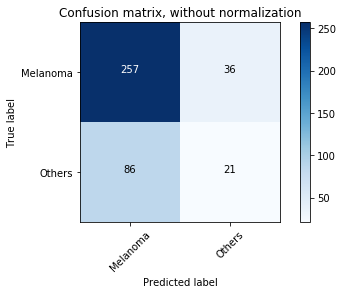

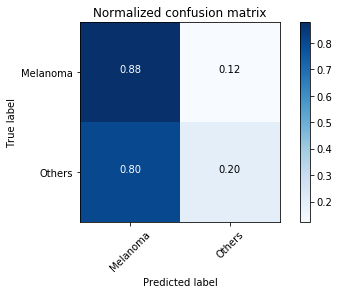

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class_names = ["Melanoma","Others"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [23]:
confusion_matrix(y_test,y_pred_class)

array([[281,  12],
       [103,   4]], dtype=int64)

In [ ]:
#VGG16

model_vgg = vgg16.VGG16(include_top=False,weights=None)

#Create your own input format (here 3x200x200)
inputs = Input(shape=(128,256,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg(inputs)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

#Create your own model 
model_vgg = Model(input=inputs, output=x)
model_vgg.compile('adam',loss='binary_crossentropy',metrics = ['accuracy'])
#get_model_memory_usage(8, model_vgg)


In [ ]:
model_checkpoint = ModelCheckpoint('./vgg_classification.hdf5',save_best_only=True)
tb = TensorBoard(log_dir='./Graph/vgg_classification/')
history = model_vgg.fit(x_train,y_train,epochs=10,batch_size=4,class_weight=(0.5,2.4),validation_data = (x_test,y_test),callbacks=[model_checkpoint,tb])